# <font color="#114b98">Conception d'une application au service de la santé publique</font>
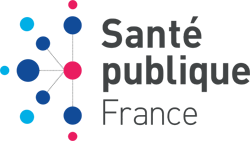

## <font color="#00afe6">Analyse exploratoire des données</font>

Après avoir nettoyé les données issues de la base OpenFoodFacts dans le notebook PSanté_01_nettoyage, nous avons exporté un nouveau dataset cleané que nous allons ici pouvoir analyser. 

Nous réaliserons ici des analyses univariées, bivariées et multivariées ainsi qu'une réduction dimensionnelle.

## <font color="#00afe6">Sommaire</font>

1. [Analyses univariées](#section_1)    
    1.1. [Analyse des dates de création et modification de produits](#section_1_1)   
    1.2. [Les contributeurs à la base OpenFoodFacts](#section_1_2)     
    1.3. [Répartition des Nutriscores et ANOVA](#section_1_3)     
    1.4. [Analyse des corrélations linéaires](#section_1_4)     
2. [Analyses multivariées : Régression linéaire multivariée](#section_2)     
    2.1. [Baseline](#section_2_1)     
    2.2. [Première régression linéaire](#section_2_2)     
    2.3. [Régression linéaire avec catégorie produits](#section_2_3)          
3. [Réduction dimensionnelle](#section_3)     
    3.1. [Eboulis des valeurs propres](#section_3_1)     
    3.2. [Cercle des corrélations](#section_3_2)     
    3.3. [Projection des produits sur les plans factoriels](#section_3_3)     
    3.4. [Qualité de représentation de la réduction de dimension](#section_3_4)     

In [ ]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lecture et importation du dossier input des datas
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### <font color="#ea1c60" id="section_1">1. Analyses univariées</font>

Commençons par charger le **jeu de données nettoyées** et regardons une rapide description : 

In [ ]:
datas = pd.read_csv('../input/enopenfoodfactsorgproducts/cleaned_openfoodfacts.csv', 
                    sep='\t',
                    index_col=False,
                    parse_dates=[3,4],
                    low_memory=False)
datas.head()

In [ ]:
datas.info()

In [ ]:
datas.describe()

Suite au nettoyage effectué dans le Notebook précédent, les valeurs médianes, écarts-type et valeus max semblent être cohérentes compte tenu du volume de données. 

#### <font color="#114b98" id="section_1_1">1.1. Analyse des dates de création et modification de produits</font> 

In [ ]:
add_per_year = datas['code'].groupby(by=datas['created_datetime'].dt.year).nunique()
modified_per_year = datas['code'].groupby(by=datas['last_modified_datetime'].dt.year).nunique()

fig=plt.figure(figsize=(12,8))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.set_style("whitegrid")
plt.plot(add_per_year, 
         color="#114b98", 
         label="Ajouts")
plt.plot(modified_per_year, 
         color="#00afe6", 
         label="Modifications")
plt.title("Evolution des créations et modifications de produits par année", 
          fontdict=font_title)
plt.xlabel("Année")
plt.ylabel("Nombre de produits")
plt.legend()
plt.show()

On remarque que les ajouts dans la base OpenFoodFacts se sont accélérés à partir de 2016. Les modifications de produits quant à elles se sont intensifiées nettement à partir de 2019 avec un pic pour le moment en 2020.

In [ ]:
modified_products = round((datas[datas['last_modified_datetime'] > datas['created_datetime']].shape[0] / datas.shape[0])*100,2)
print("{:02}% des produits ont été modifiés au moins 1 fois depuis leur création.".format(modified_products))

#### <font color="#114b98" id="section_1_2">1.2. Les contributeurs à la base OpenFoodFacts</font> 

Regardons à présent la répartition des entrées par contributeurs :

In [ ]:
creators = datas.groupby(by='creator')['code'].nunique().sort_values(ascending=False)

In [ ]:
def plot_contributor(n=5):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

    explodes = np.zeros(n)
    explodes[0] = .1

    def pct_tot(pct):
        tot = round(pct*creators[:n].sum(),0)
        tot_pct = tot/creators.sum()
        return "{:.1f}%\n({:.0f})".format(tot_pct,(tot/100))

    plt.pie(creators[:n], labels=creators[:n].index, 
            startangle=45, 
            shadow=True,
            explode=explodes,
            autopct=lambda pct: pct_tot(pct),
            textprops=dict(color="black",size=12, weight="bold"))
    plt.title("Qui sont les {:d} meilleurs contributeurs ?".format(n), 
              fontdict=font_title)
    plt.show()

In [ ]:
plot_contributor(n=5)

#### <font color="#114b98" id="section_1_3">1.3. Répartition des Nutriscores et ANOVA</font>

Nous avons tenté de calculer simplement les nutriscores et nutrigrades dans le Notebook *PSanté_01_nettoyage*. Cependant, les erreurs constatées étant supérieur à 50%, nous n'avons pas imputé les valeurs manquantes à cette étape. Regardons à présent la répartition des nutriscores déjà complétés dans le dataset initial :

In [ ]:
nutrigrades = datas.groupby(by='nutriscore_grade')['code'].nunique().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

explodes = np.zeros(5)
explodes[0] = .1

plt.pie(nutrigrades, labels=nutrigrades.index, 
        startangle=0, 
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black",size=12, weight="bold"))
plt.title("Répartition des Nutrigrades", fontdict=font_title)
plt.show()

On peut également visualiser l'**évolution des différents nutrigrades dans le temps** :

In [ ]:
#On s'occupe ici uniquement des nutriscores et nutrigrades complétés
datas_nutri = datas[(datas['nutriscore_grade'].isnull()==False) & 
                   (datas['nutriscore_score'].isnull()==False)]

ng_per_year = datas_nutri[['code','nutriscore_grade']].groupby(by=['nutriscore_grade',datas_nutri['created_datetime'].dt.year]).nunique().reset_index()
cum_per_year = datas_nutri[['code']].groupby(by=datas_nutri['created_datetime'].dt.year).nunique().reset_index()
ng_per_year = pd.merge(ng_per_year, cum_per_year, how="left", left_on="created_datetime", right_on="created_datetime")
ng_per_year = ng_per_year.rename(columns={'created_datetime':'year', 'code_x':'nb_nutrigrade', 'code_y':'total_grade'})
ng_per_year['nutrigrade_rate'] = (ng_per_year['nb_nutrigrade'] / ng_per_year['total_grade'])*100

fig =plt.figure(figsize=(12,8))
ax = sns.lineplot(x='year', y='nutrigrade_rate', hue='nutriscore_grade', data=ng_per_year)
plt.xlabel("Année")
plt.ylabel("Taux du Nutrigrade")
plt.title("Evolution de la répartition des Nutrigrades au fil des années", fontdict=font_title)
plt.show()

On voit ici clairement que la mise en place de la Loi de Santé 2017 et du calcul du Nutri-score par l'équipe du Pr. Serge Hercberg a fait chuter la part de produits considérés Nutri-score A au profit des produits typés D et E.

Regardons également les relations par paires de variables :

In [ ]:
sns.pairplot(datas_nutri.sample(frac=0.05), hue="nutriscore_grade")

L'analyse de ces pairplots montre déjà des relations linéaires entre certaines variables. On remarque également le regroupement par Nutrigrade sur la plupart des features. Regardons à présent la répartition de ces Nutri-score et Nutri-grades

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(21,8))
fig.suptitle(r"Répartition des scores Nutriscore et de leurs grades" "\n", fontdict=font_title, fontsize=22)

sns.histplot(data=datas_nutri.sort_values("nutriscore_grade"), x="nutriscore_grade", hue="nutriscore_grade", ax=axes[0])
axes[0].set_title('Grades de Nutriscores')
axes[0].set_xlabel("Grade Nutriscore")
axes[0].set_ylabel("Nombre de produits")

sns.histplot(data=datas_nutri.sort_values("nutriscore_grade"), x="nutriscore_score", hue="nutriscore_grade", ax=axes[1])
axes[1].set_title('Scores de Nutriscores')
axes[1].set_xlabel("Score Nutriscore")
axes[1].set_ylabel("Nombre de produits")

plt.show()

La répartition des Nutriscores est quasi équitable avec tout de même une prépondérance pour la classe D. On peut également projeter la **répartition des scores nutriscore par catégorie de produits** (`pnns_groups_1`) 

In [ ]:
n_sub = len(datas_nutri['pnns_groups_1'].unique())
n_col = 2
fig, axes = plt.subplots(int(n_sub/n_col), n_col, sharex=False, sharey=False, figsize=(21,int(3*n_sub)))
axes = np.array(axes)
fig.suptitle("Distribution des scores Nutriscore par catégorie", fontdict=font_title, fontsize=22)
i=0
for ax in axes.reshape(-1):
    cat = datas_nutri['pnns_groups_1'].unique()[i]
    subset = datas_nutri[datas_nutri['pnns_groups_1']==cat].sort_values("nutriscore_grade")
    sns.histplot(data=subset, x="nutriscore_score", hue="nutriscore_grade", ax=ax)
    ax.set_title('Catégorie : {}'.format(cat))
    ax.set_xlabel("Score Nutriscore")
    ax.set_ylabel("Nombre de produits")
    i+=1
plt.show()

Afin de vérifier si la catégorie `pnns_groups_1` ou `pnns_groups_2` influence rééllement le Nutriscore, nous pouvons réaliser **une ANOVA (Analyse de la variance)**. Le choix de ce test est dû au fait que nous étudions 1 variable qualitative comparativement à une variable quantitative.

Les hypothèses posées seront donc les suivantes :
- ***H0*** : La distribution des échantillons est similaire *(et donc la catégorie n'a aucune influence sur le Nutriscore)*.
- ***H1*** : Une ou plusieurs distributions sont inégales.

Pour commencer, nous pouvons projeter les boxplots de la répartition des nutriscores par catégorie `pnns_groups_1` pour également vérifier les hypothèses de départ liées à l'ANOVA à savoir :
- Les observations dans chaque échantillon sont indépendantes et distribuées de manière identique (iid). 
- Les observations dans chaque échantillon ont la même variance.
- Les observations de chaque échantillon sont normalement distribuées. 

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = sns.boxplot(data=datas_nutri, x='pnns_groups_1', y='nutriscore_score')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title("Influence de la catégorie de produit sur le Nutriscore", fontdict=font_title)
plt.show()

On remarque ici ques les catégories semblent assez différentes, même si l'ordre de grandeur des écart est relativement faible. Dans les histogrammes ci-dessus, nous voyons cependant que les distributions ne semblent pas suivre la loi normale.      
La question sera à présent de savoir si ces écarts sont significatifs ou pas via l'analyse de variance :

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

anova_category = smf.ols('nutriscore_score~pnns_groups_1', data=datas_nutri).fit()
print(anova_category.summary())

In [ ]:
#Tableau d'analyse de variance
sm.stats.anova_lm(anova_category, typ=2)

Les résultats du **test de Fisher** nous indiquent ici une p-value de 0 pour l'ensemble des catégories, donc inferieur au niveau de test de 5%. Nous rejettons donc l'hypothèse *H0* selon laquelle les ditributions sont identiques.        
**La catégorie de produit a donc bien une influence sur le Nutriscore**.

#### <font color="#114b98" id="section_1_4">1.4. Analyse des corrélations linéaires</font>
Pour analyser les corrélations linéaires entre nos variables quantitatives, nous allons réaliser un **test de corrélation de Pearson** et afficher ses résultats dans un heatmap :

In [ ]:
#Matrice des corrélations
corr_mat = datas_nutri.corr()
#heatmap
fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_mat, square=True, linewidths=0.01, annot=True, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson", fontdict=font_title)
plt.show()

Cette matrice des corrélations ne nous apporte pas rééllement d'informations mais confirme mathématiquement des éléments logiques : `salt_100g` est très fortement corrélé avec `sodium_100g`, `fat_100g` avec `satured-fat_100g`... Il faudra cependant tenir compte de ces fortes corrélation dans nos modèles, la **colinéarité** dégradant les performances.


On remarque également que des **corrélations linéaires existent entre le nutriscore et certaines variables** plus que d'autres :

In [ ]:
fig = plt.figure(figsize=(10,10))
cols = corr_mat.nlargest(11,'nutriscore_score')['nutriscore_score'].index
corr_nutriscore = corr_mat.loc[cols, cols]
sns.heatmap(corr_nutriscore, cbar=True, annot=True,
            fmt='.2f', annot_kws={'size': 9},
            square=True, linewidths=0.01, cmap='coolwarm')
plt.title("Corrélations de Pearson avec le Nutriscore", fontdict=font_title)
plt.show()

Logiquement, les variables utilisées dans le calcul des nutriscore sont bien corrélées linéairement à ce dernier. **<font color="green">Notre concept d'application pourrait donc être d'estimer le grade Nutriscore et le score correspondant grâce à une régression linéaire multiple sur les variables les plus corrélées, tout en utilisant la catégorie du produit<font>**. 
    
Nous allons vérifier si cette théorie fonctionne grâce à la **régression linéaire multivariée**.

### <font color="#ea1c60" id="section_2">2. Analyses multivariées : Régression linéaire multivariée.</font>

Quand une variable cible est le fruit de la corrélation de plusieurs variables prédictives, on parle de **Multivariate Regression** pour faire des prédictions. Toutes ces variables prédictives seront utilisées dans notre modèle de régression linéaire multivariée pour trouver une **fonction prédictive** du type :

$$\large F(X) = \epsilon + \alpha x_1 + \beta x_2 + \gamma x_3 + ... + \omega x_n$$

où :
- $\large \epsilon$ est une constante,
- $\large \alpha , \beta , \gamma$ représentent les coefficients de notre fonction prédictive $\large F(X)$,
- $\large X$ est un vecteur de variables prédictives.

Dans un premier temps, nous allons considérer comme **variables prédictives uniquement l'ensemble des variables numériques**. Nous étenderons par la suite le modèle aux variables catégorielles. 

In [ ]:
# Nous partons du dataset dont les nutriscores sont complétés.
numerical_features = datas_nutri.select_dtypes(include=['float64','int64'])

y = numerical_features['nutriscore_score'].values
X = numerical_features.drop('nutriscore_score', axis=1)

Nous devons ici **supprimer les variables fortement corrélées** à savoir : `sodium_100g`, `carbohydrates_100g` et `fat_100g`

In [ ]:
X.drop(['sodium_100g','carbohydrates_100g','fat_100g'], axis=1, inplace=True)

Nous allons devoir **standardiser nos données** afin de les placer sur la même echèle *(moyenne = 0 et écart-type = 1)*

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Puis nous allons spliter nos données en 1 jeu d'entrainement et un jeu de test *(30%)* :

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#### <font color="#114b98" id="section_2_1">2.1. Baseline</font>

Nous avons donc à notre disposition un jeu d'entrainement et un jeu de test pour nos prédictions du Nutriscore. Comme dans toute approche de modélisation, nous allons devoir vérifier que notre modèle est réellement performant. La régression linéaire étant un modèle relativement simple, nous allons devoir **réaliser une baseline**. Nous utiliserons la méthode `DummyRegressor` de la librairie Sklearn :

In [ ]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)
dummy_pred = dummy_reg.predict(X_test)

Nous allons calculer plusieurs métriques pour cette baseline :

In [ ]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "MSE", "RMSE", "R²"], "Résultats":[mae, mse, rmse, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [ ]:
dummy_metrics = metrics_model(y_test, dummy_pred).rename(columns={'Résultats':'Baseline'})
dummy_metrics

#### <font color="#114b98" id="section_2_2">2.2. première régression linéaire</font>
Nous avons donc nos métriques de Baseline et nous allons à présent pouvoir réaliser notre premier modèle de régression linéaire multivariée et le comparer aux métriques de base obtenues :

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [ ]:
lr_metrics = metrics_model(y_test, lr_pred).rename(columns={'Résultats':'LinearRegression'})
lr_metrics = pd.concat([dummy_metrics,lr_metrics['LinearRegression']], axis=1)
lr_metrics

Les métriques de ce premier modèle sont bien meilleurs que la baseline. Le R² (coefficient de détermination) qui est le carré du coefficient de corrélation linéaire, est de 0.64 ce qui en fait une base correcte de prédiction. Nous pouvons d'ailleurs projeter les erreurs de prédictions :

In [ ]:
def plot_pred_true(y_true, y_pred):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réélles")
    plt.ylabel("Valeurs prédites")
    plt.title("Projection des valeurs prédites en fonction des valeurs réélles", fontdict=font_title, fontsize=18)
    plt.show()

In [ ]:
plot_pred_true(y_true=y_test, y_pred=lr_pred)

On remarque une dispersion encore importante des prédictions aux valeurs test. Ce premier modèle peut être amélioré, par exemple en ajoutant la catégorie du produit.  

#### <font color="#114b98" id="section_2_3">2.3. Régression linéaire avec catégorie produits</font>

Ajoutons à présent dans le modèle les 2 principales variables de catégorisation de produits : `pnns_groups_1`, `pnns_groups_2`. Ces variables catégorielles vont devoir être encodées pour être incorporées au modèle. Pour cette modélisattion, nous allons réaliser un OneHotEncoder.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_features = list(X.columns)
numerical_transformer = StandardScaler()

categorical_features = list(['pnns_groups_1', 'pnns_groups_2'])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

X = datas_nutri[numerical_features + categorical_features]
y = datas_nutri['nutriscore_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

pipeline_lr.fit(X_train, y_train)
plr_pred = pipeline_lr.predict(X_test)

plr_metrics = metrics_model(y_test, plr_pred).rename(columns={'Résultats':'LinearRegression cat'})
plr_metrics = pd.concat([lr_metrics,plr_metrics['LinearRegression cat']], axis=1)
plr_metrics

In [ ]:
from sklearn import set_config

set_config(display='diagram')
pipeline_lr

Les métriques pour ce second modèle sont meilleures que le premier modèle simple de régression linéaire. En effet, nous avons vu préalablement que l'hypothèse selon laquelle la catégorie influençait le Nutriscore était vérifiée.

Pour améliorer encore les performances, nous pourrions traiter d'autres types d'algorithmes comme la régression Ridge par exemple ou encore la régression lasso.

Nous allons à présent faire une réduction de dimensions afin de trouver les meilleurs plans factoriels du jeu de données.

### <font color="#ea1c60" id="section_3">3. Réduction dimensionnelle.</font>

Pour cette réduction du nombre de dimensions, nous allons réaliser une **Analyse en Composantes Principale *(PCA)***, l'une des méthodes d'analyse de données multivariées les plus utilisées. Elle permet d'explorer des jeux de données multidimensionnels constitués de variables quantitatives.

Pour cela, nous utiliserons la méthode `PCA` du module `decomposition` Sklearn sur les variables numériques centrées et réduite. Nous prendrons en variable illustrative de cette ACP le grade Nutriscore du produit.

In [ ]:
from sklearn.decomposition import PCA

#Centrage et réduction
X = datas_nutri.select_dtypes(include=['float64','int64'])
X_scaled = scaler.fit_transform(X)

#Instanciation de l'ACP
pca = PCA(svd_solver='full').fit(X_scaled)
X_projected = pca.transform(X_scaled)

#### <font color="#114b98" id="section_3_1">3.1. Eboulis des valeurs propres</font>

Afin d'avoir un aperçu du nombre de composantes nécessaire à l'analyse, nous allons projeter l'**éboulis des valeurs propres** :

In [ ]:
#Variances expliquées
varexpl = pca.explained_variance_ratio_*100

#Projection de l'éboulis des valeurs propres
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)
plt.plot(np.arange(len(varexpl))+1, varexpl.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres", fontdict=font_title)
plt.show(block=False)

In [ ]:
print("Le premier plan factoriel couvrira une inertie de {:.2f}% et le second plan : {:.2f}%.".format(varexpl[0:2].sum(),
                                                                                                     varexpl[0:4].sum()))

**Les 2 premiers plans factoriels couvrent une inertie d'un peu plus de 77%**. Une analyse sur $F_1$ et $F_2$ semble donc cohérente.

Projetons à présent le **cercle des corrélations** :

#### <font color="#114b98" id="section_3_2">3.2. Cercle des corrélations</font>

In [ ]:
#Espace des composantes principales
pcs = pca.components_

#Matrice des corrélations variables x facteurs
p = X.shape[1]
sqrt_valprop = np.sqrt(pca.explained_variance_)
corvar = np.zeros((p, p))
for dim in range(p):
    corvar[:,dim] = pcs[dim,:] * sqrt_valprop[dim]

#on affiche pour les deux premiers plans factoriels 
corr_matrix = pd.DataFrame({'feature':X.columns,'CORR_F1':corvar[:,0],'CORR_F2':corvar[:,1], 
              'CORR_F3':corvar[:,2], 'CORR_F4':corvar[:,3]})
corr_matrix

In [ ]:
#Variable Illustrative
ivNutrigrade = datas_nutri['nutriscore_grade'].values

#Encodage des grades
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
ivNutrigrade = encoder.fit_transform(ivNutrigrade)
ivNutrigrade = ivNutrigrade.reshape((ivNutrigrade.shape[0],1))

#Corrélation de la variable illustrative avec les axes factoriels 
corrIv = np.zeros((ivNutrigrade.shape[1],p))
for j in range(p): 
    for k in range(ivNutrigrade.shape[1]): 
        corrIv[k,j] = np.corrcoef(ivNutrigrade[:,k],X_projected[:,j])[0,1]

In [ ]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0, 
               illustrative_var_label=None, illustrative_var_corr=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            fig=plt.figure(figsize=(10,10))
            fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=fig.add_subplot(111)
            ax.set_aspect('equal', adjustable='box') 

            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                plt.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #variable illustrative
            if illustrative_var_label is not None :
                plt.annotate(illustrative_var_label,
                             (illustrative_var_corr[0,d1],illustrative_var_corr[0,d2]),
                             color='g')
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                                   illustrative_var_corr[0,d1],illustrative_var_corr[0,d2], 
                                   angles='xy', scale_units='xy', scale=1, color="g", alpha=0.5)

            #ajouter les axes 
            plt.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            plt.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)

In [ ]:
cerle_corr(pcs, 4, pca, [(0,1),(2,3)], labels = np.array(X.columns), 
           illustrative_var_label="Nutriscore_grade", illustrative_var_corr = corrIv)

#### <font color="#114b98" id="section_3_3">3.3. Projection des produits sur les plans factoriels</font>

On peut à présent visualiser la projection des individus sur ces premiers plans factoriels et donc en 2D :

In [ ]:
def plot_plans_factoriels(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des {} individus sur F{} et F{}".format(X_projected.shape[0], d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)

In [ ]:
plot_plans_factoriels(X_projected, 4, pca, [(0,1),(2,3)], illustrative_var = ivNutrigrade)

#### <font color="#114b98" id="section_3_4">3.4. Qualité de représentation de la réduction de dimension</font>

Afin d'analyser la performance de notre réduction de dimension via PCA, nous allons regarder le ***COS²*** et la **CTR***.

On peut calculer la **qualité de représentation des variables *(COS²)*** en élevant la corrélation au carré :

In [ ]:
#Calcul des COS²
cos2var = corvar**2
df_cos2var = pd.DataFrame({'feature':X.columns,'COS2_F1':cos2var[:,0],
                           'COS2_F2':cos2var[:,1], 'COS2_F3':cos2var[:,2],
                           'COS2_F4':cos2var[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,10))
sns.heatmap(df_cos2var, annot=True, cmap="YlGnBu")
plt.title("Qualité de représentation des variables (COS²)", fontdict=font_title)
plt.show()

On remarque ici clairement, avec le cercle et le COS², les corrélations importantes entre l'energie et le caractère "gras" des produits. L'axe  $F_1$  va donc parfaitement représenter le facteur "énergétique" et l'axe  $F_2$  quant à lui représentera bien les qualités "sucré / salé".

Regardons à présent la **contribution des variables aux axes *(CTR)***, elle aussi également basée sur le carré de la corrélation, mais relativisée par l’importance de l’axe :

In [ ]:
#contributions 
ctrvar = cos2var 
for k in range(p): 
    ctrvar[:,k] = ctrvar[:,k]/pca.explained_variance_[k] 

df_ctrvar = pd.DataFrame({'feature':X.columns,'CTR_F1':ctrvar[:,0],'CTR_F2':ctrvar[:,1],
                         'CTR_F3':ctrvar[:,2], 'CTR_F4':ctrvar[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_ctrvar, annot=True, cmap="YlGnBu")
plt.title("Contribution des variables aux axes (CTR)", fontsize=22)
plt.show()

Afin de **tester une dernière modélisation à partir des variables synthétiques** $F_1$ à $F_4$, nous allons les ajouter à notre dataset initial :

In [ ]:
df_syn_var = pd.DataFrame(X_projected[:,:4], index=datas_nutri.index, 
                          columns=["F"+str(i+1) for i in range(4)])
datas_extend = pd.concat([datas_nutri, df_syn_var], axis=1)
datas_extend.head()

In [ ]:
#Les variables synthétiques sont déjà standardisées
numerical_features = ['F1','F2','F3','F4']

categorical_features = list(['pnns_groups_1', 'pnns_groups_2'])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

pipeline_lr_pca = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

X = datas_extend[numerical_features + categorical_features]
y = datas_extend['nutriscore_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

pipeline_lr_pca.fit(X_train, y_train)
plr_pca_pred = pipeline_lr_pca.predict(X_test)

plr_pca_metrics = metrics_model(y_test, plr_pca_pred).rename(columns={'Résultats':'LinearRegression PCA'})
plr_pca_metrics = pd.concat([plr_metrics,plr_pca_metrics['LinearRegression PCA']], axis=1)
plr_pca_metrics

In [ ]:
plot_pred_true(y_true=y_test, y_pred=plr_pca_pred)

On remarque ici une très grosse perte de précision si l'on base la modélisation sur les variables synthétiques de la PCA. **La réduction dimensionnelle, à ce stade de préparation des données n'est pas pertinante pour notre application**. En effet, le nettoyage initial a déjà permis de réduire considérablement le nombre de variables du dataset.